# スライディングウィンドウを用いた特徴量抽出
ここでは、加速度データやアノテーションファイルに対して様々な処理をし、特徴量を抽出していただきます。  
※Pythonプログラムの中でいくつかのモジュールを使用しています。
コマンドプロンプトからJupyter Notebookを利用されている方は、  
- Numpy
- Pandas
- Scipy
- matplotlib

をインストールしてください

## 本章の構成  

- 加速度データの処理
- アノテーションデータの処理
- アノテーションデータと加速度データの結合
- 特徴量の抽出

## 加速度データの処理

### 加速度データの読み取り
Pythonを用いて解析を行う場合、Numpyの配列やPandasのデータフレームを用いてデータを処理することが多いです。今回は、読み込んだCSVファイルのデータをPandasのデータフレームに変換しています。  
自作したファイルを利用する場合、カンマに囲まれているファイル名を変更してください。

In [1]:
import pandas as pd
import numpy as np

# csvの読み取り
df= pd.read_csv("sample/Acc_sample.csv")

### 加速度データの中身
shape関数でデータの行数と列数を確認してみましょう。  
出力結果は(行数, 列数)となっています。

In [2]:
df.shape

(83402, 4)

次にhead関数を用いて加速度データがどのようなデータを含んでいるのか確認してみましょう。 DateTimeはデータを取得した年月日と0.001秒単位までの時間を示しています。そのため、〇〇〇〇△△□□〇〇△△□□×××の並びで、〇〇〇〇年△△月□□日 〇〇時△△分□□.×××秒にこのデータが摂られたことを示しています。 また、Ax、Ay、Azはそれぞれ3軸加速度センサにおけるx軸、y軸、z軸の値を示しています。

In [3]:
df.head(5)

,#DateTime,Ax,Ay,Az
0,20210914152220720,-0.537475,6.081011,7.464201
1,20210914152220730,-0.480017,6.100163,7.540813
2,20210914152220739,-0.570993,6.277327,7.761069
3,20210914152220749,-0.757732,6.478431,7.914291
4,20210914152220759,-0.834343,6.578983,7.957386


### データの可視化
せっかくなのでデータを可視化してみましょう。
値が上下している部分としていない部分がはっきりしていることがわかります。
恐らく値の上下が少ない部分は立っているなど動きが少ないと考えられます。
データフレームのplotを用いて加速度をグラフ化し、可視化しています。
それに加えてmatplotlibのpyplotもよく用いられます。気になる方は[こちら](https://www.sejuku.net/blog/60895)を参照してみてください。

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

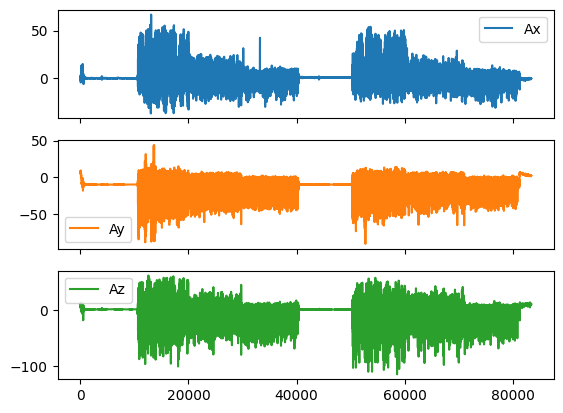

In [4]:
df.plot(y=['Ax', 'Ay', 'Az'], subplots=True)

## アノテーションデータの処理
### アノテーションデータの読み込み
ここではどのタイミングでどのような行動を行っていたか、正解のラベルを付与するためのアノテーションファイルを読み込み、センサと同期をとっていきます。  
センサデータの読み込みと同様にアノテーションファイルを読み込みます。

In [5]:
Text= pd.read_csv("sample/Annotation_sample.csv", header=None)

### アノテーションファイルの中身

こちらも中身を確認しましょう。 

In [6]:
Text.shape

(8, 3)

中身を確認してみましょう。
0列目のデータは行動が始まった時間、1列目のデータは行動が終わった時間、2列目のデータは0列目から1列目の時間に行われていた行動の名称を示しています。

In [7]:
print(Text)

                       0                      1         2
0  20210914 15:22:30.751  20210914 15:24:00.913  Standing
1  20210914 15:24:03.565  20210914 15:25:33.271   Jogging
2  20210914 15:25:34.081  20210914 15:27:07.862  Skipping
3  20210914 15:27:09.921  20210914 15:28:47.941   Walking
4  20210914 15:28:50.024  20210914 15:30:23.969  Standing
5  20210914 15:30:25.579  20210914 15:31:59.047   Jogging
6  20210914 15:32:01.024  20210914 15:33:44.038  Skipping
7  20210914 15:33:45.830  20210914 15:35:18.972   Walking


しかし、現在のままでは半角のスペースやコロン(：)などによりうまく処理ができないため、0列目と1列目の値を数値のみに変換します。

In [8]:
for index in range(len(Text.index)):
  ss = Text.iloc[index, 0]
  Text.iloc[index, 0] = int((ss[0:8] + ss[9:11] + ss[12:14] + ss[15:17] + ss[18:21]))
  ss = Text.iloc[index, 1]
  Text.iloc[index, 1] = int((ss[0:8] + ss[9:11] + ss[12:14] + ss[15:17] + ss[18:21]))

print(Text)

                   0                  1         2
0  20210914152230751  20210914152400913  Standing
1  20210914152403565  20210914152533271   Jogging
2  20210914152534081  20210914152707862  Skipping
3  20210914152709921  20210914152847941   Walking
4  20210914152850024  20210914153023969  Standing
5  20210914153025579  20210914153159047   Jogging
6  20210914153201024  20210914153344038  Skipping
7  20210914153345830  20210914153518972   Walking


## アノテーションデータと加速度データの結合
### アノテーションされた加速度データの作成
簡単な下処理を得て、アノテーションデータと加速度データのDateTime表記を揃えることができたため、センサデータにアノテーションデータを結び付けていきます。

In [9]:
df['Annotation'] = 'None'  #データフレームに'Annotation'というカラムを追加する

#センサデータにアノテーションがついてる部分はAnnotationのカラムに、行動名を上書きする
for i in range(Text.shape[0]):
  for j in range(df.shape[0]):
    if (int(Text[0][i]) <= int(df['#DateTime'][j])) & (int(Text[1][i]) >= int(df['#DateTime'][j])):
      df.iloc[j,4] = Text.iloc[i,2]
    elif int(Text[1][i]) < int(df['#DateTime'][j]):
      break

中身を確認しましょう。
DateTime、Ax、Ay、Azは加速度センサのデータと同じですが、最後にAnnotationという列が追加されています。
このAnnotationは、取得された時間に行動ラベルが割り振られていたかを示しており、加速度のデータと結び付けられています。また、行動ラベルが割り振られていない場合、「None」が入力され、行動ラベルが割り当てられている場合、その行動ラベルの名称が割り振られています。
例としてサンプルデータで50000行～50005行を出力してみると「Standing」というラベルが割り振られていることがわかります。

In [10]:
df2 = df

print(df2)
print(df2[50000:50005])

               #DateTime        Ax        Ay        Az Annotation
0      20210914152220720 -0.537475  6.081011  7.464201       None
1      20210914152220730 -0.480017  6.100163  7.540813       None
2      20210914152220739 -0.570993  6.277327  7.761069       None
3      20210914152220749 -0.757732  6.478431  7.914291       None
4      20210914152220759 -0.834343  6.578983  7.957386       None
...                  ...       ...       ...       ...        ...
83397  20210914153544777 -0.575781  2.216936  9.034730       None
83398  20210914153544786 -0.614086  2.197783  9.029942       None
83399  20210914153544796 -0.590145  2.111595  9.178376       None
83400  20210914153544806 -0.547052  2.058925  9.245411       None
83401  20210914153544815 -0.561416  2.125960  9.379479       None

[83402 rows x 5 columns]
               #DateTime        Ax         Ay        Az Annotation
50000  20210914153022789  0.506352  -9.887628  0.578773   Standing
50001  20210914153022799  0.559022  -9.940298  0

## 特徴量の抽出

ここまで、ある時点でのセンサデータでどんな行動が行われていたかを表すアノテーションされた加速度データを作成してきました。  
次にスライディングウィンドウで全体から部分的にデータを取り出し、特徴量を計算していきましょう。  

## スライディングウィンドウ
今回の実験のように、連続的に得られるセンサデータを処理する場合、センシングを開始してから終了までずっと続く半無限長のため、認識対象とする範囲を決め、その範囲を部分系列として抽出する必要があります。このような場合に、スライディングウィンドウという技術が用いられます。  
ウィンドウのサイズ*W*は高速フーリエ変換を行い、周波数領域の特徴量を抽出するために、128や256など、2のべき乗になっていることが多いです。  
また、スライド幅*S*は、データの周期性を失わないように、ウィンドウサイズの何％という数字が設定されることが多くあります。  
図ではウィンドウサイズの50%をスライドしています。

<img src="Image/image_FE/SW.svg" width="500">


### 特徴量(統計)

まずは統計的特徴量を抽出してみましょう。
統計的特徴量には最大、最小、平均、分散、標準偏差など多くの種類があります。  
他にも知りたい方は[こちら](https://resanaplaza.com/2021/09/23/)を参照してみてください。  
今回は平均と標準偏差を計算してみます。  
Numpyモジュールを用いれば簡単に計算することができます。


#### 平均と標準偏差

In [11]:
def Calc_Time(signalData):
  Mean = np.mean(signalData) # 平均値
  Std = np.std(signalData - Mean)  #標準偏差

  return [Mean, Std]

#### Root Mean Square

今、X軸加速度がプラスのとき右への加速、マイナスのとき左への加速とします。このとき、ある単位時間当たりに左右に同じくらい加速していれば、その平均値は0となりますね。従って、特徴量の一つである平均値は、符号により左右の加速を打ち消し合う場合があります。これを一つの特徴として表すことも当然ありです。ただ、このような打ち消し合いがされない特徴量を欲しい場合もあるでしょう。これを実現する特徴量に、二乗平均平方根があります。英語で書くとRoot Mean Squareとなり、工学の分野ではRMSとよく呼ばれます。例えば、ある時間 i から i+n のX軸加速度のRMSは、
$$ 
RMS = \sqrt{\dfrac{1}{n}{\displaystyle{\sum_{t = i}^{i+n}}x_{t}}}
$$
で定義されます。他の軸も同様の式で算出可能です。ある時間 t の信号を二乗することで、すべてプラス方向に信号が整理されます。その後、平方根を取ることで、二乗され見かけ上値が大きくなってしまった部分がキャンセルされます。最後に、その平均値を算出しています。つまり、RMSとは、左右の向きを気にせずに、左右両者の方向においてその全体の加速の大きさを表す特徴になります。上下方向の軸であれば、上下両方においてその全体の加速の大きさを表します。

In [12]:
# RMSを求める関数
def Calc_RMS(signalData):
    a = signalData * signalData  # 二乗
    sum_a = np.sum(a)  # 総和
    sqrt_a = np.sqrt(sum_a) # 平方根
    RMS = np.mean(sqrt_a) # 平均値
    return RMS

### 特徴量抽出(周波数)
次に周波数領域の特徴量を抽出してみましょう。
今回はエネルギーと周波数領域エントロピーを抽出します。  
より詳しく知りたい場合、[こちら](http://int-info.com/PyLearn/PyLearnSIG03.html)を参照してみてください

#### エネルギーとエントロピー  
フーリエ変換によって得られた周波数成分について、振幅の自乗はその周波数成分がもつエネルギーとなります。そして、特徴量としてよく用いられるものは、部分系列全体が持つエネルギーのため、角周波数成分のエネルギーの総和をエネルギーとしています。  
N個のデータによる部分系列xのフーリエ変換結果を、
$$
F(x) = \{f_{0},f_{1},f_{2},...,f_{N-1}\}
$$
とすると、部分系列のエネルギー$G_{energy}$は、
$$
G_{energy} = {\displaystyle{\sum_{i=0}^{N-1}}|f_{i}|^2}
$$
となります。  
また、周波数領域エントロピーは、周波数成分のばらつきを表す値です。  
周波数エントロピー$G_{fde}$は、
$$
G_{fde} = {- \displaystyle{\sum_{i=0}^{N-1}}P_{i}log P_{i}}
$$
と定義されます。

### 窓関数
周波数領域での特徴量を抽出する場合、通常はフーリエ変換を用いて時間領域のデータを周波数領域のデータに変換します。しかし、フーリエ変換は変換対象となるデータに周期性があることを仮定するため、波形全体のフーリエ変換の結果と部分系列のフーリエ変換の結果に差が生じてしまいます。そこで、フーリエ変換を有限区間で行うために**窓関数**が用いられます。  
窓関数には、矩形窓、ハン窓、ハミング窓、ブラックマン窓など様々な種類があり、周波数特性によって使い分けることが多いです。詳しくは、[こちら](https://cognicull.com/ja/l8klra0e)をご覧ください  
今回は、ハン窓を用いています。  
ハン窓は周波数分解能の高さとダイナミックレンジの広さのバランスが良く、音声認識ではハミング窓とともによく用いられます。また、ハニング窓とも呼ばれます。  
ハン窓は、下記式で定義されます。
$$
ω(t) = 0.5 - 0.5 cos (\dfrac{2πt}{W - 1})
$$
また、ハン窓の形(左)と、周波数特性(右)は次のようになっています。

<img src="Image/image_FE/ハニング窓.svg" width="800">

https://cognicull.com/ja/7r5k6y75 より引用

In [13]:
from scipy.fftpack import fft
from scipy import signal

def Calc_Freq(signalData):
  L = len(signalData) # 信号長
  Win = signal.hann(L) #ハニング窓を使用

  S = np.fft.fft(Win * signalData) # 振幅スペクトル
  PowerSpectrum = (S * S.conjugate()) # パワースペクトル
  Energy = np.sum(PowerSpectrum.real)

  P = PowerSpectrum.real/np.sum(Energy)
  Entropy = -np.sum(P*np.log(P))


  return [Energy, Entropy]

### 特徴量抽出

ここで、特徴量をウィンドウごとに抽出していきます。  
ウィンドウサイズは2560msで、重なりは50%となっています。  
是非ウインドウサイズや重なりの値を変更して実験を行ってみて下さい。
また、3000msのマージンを取り、行動開始時のノイズをなくしています。  
こうして抽出された特徴量をデータフレームにします。  
コメントアウトされている部分はRMSも利用する場合です。  
お好きな方を使用、もしくはどちらも行ってみてください。  
(実行に時間がかかります。)

In [14]:
#各特徴量を格納するデータフレームを作成
df['Mean_x'] = 0
df['Std_x'] = 0
df['RMS_x'] = 0
df['Energy_x'] = 0
df['Entropy_x'] = 0
df['Mean_y'] = 0
df['Std_y'] = 0
df['RMS_y'] = 0
df['Energy_y'] = 0
df['Entropy_y'] = 0
df['Mean_z'] = 0
df['Std_z'] = 0
df['RMS_z'] = 0
df['Energy_z'] = 0
df['Entropy_z'] = 0
df['activity_label'] = 0

cols = ['Mean_x', 'Std_x','Energy_x','Entropy_x',
        'Mean_y', 'Std_y','Energy_y','Entropy_y',
        'Mean_z', 'Std_z','Energy_z','Entropy_z','activity_label']

"""
cols = ['Mean_x', 'Std_x','RMS_x','Energy_x','Entropy_x',
        'Mean_y', 'Std_y','RMS_y','Energy_y','Entropy_y',
        'Mean_z', 'Std_z','RMS_z','Energy_z','Entropy_z','activity_label']
"""

df_feature = pd.DataFrame(index=[], columns=cols)

#それぞれのパラメータの設定
Window_size = 256
over_lap = 0.5

overlap_data = Window_size * over_lap

margin = 300
index = 0
loop = 0

"""
特徴量を抽出
データフレームの'Annotation'が'None'ではない場合、
ウィンドウサイズ分のデータで特徴量を抽出する
"""
while index < df.shape[0]:

  if df['Annotation'][index] == 'None':
    index = index + 1
  else:
    count = 0
    while count < margin:
      count,index = count + 1,index + 1

    while df['Annotation'][index + Window_size] != 'None':
      signal_Data = []
      for i in range(Window_size):
        data = df.iloc[index, 1:4]
        signal_Data.append(list(data.values))
        index = index + 1
      signal_Data = np.array(signal_Data)

      feature_list = []
      Mean_x, Std_x = Calc_Time(signal_Data[:,0])
      RMS_x = Calc_RMS(signal_Data[:,0])
      Energy_x,Entropy_x = Calc_Freq(signal_Data[:,0])
    
      Mean_y, Std_y = Calc_Time(signal_Data[:,1])
      RMS_y = Calc_RMS(signal_Data[:,1])
      Energy_y,Entropy_y = Calc_Freq(signal_Data[:,1])
        
      Mean_z, Std_z = Calc_Time(signal_Data[:,2])
      RMS_z = Calc_RMS(signal_Data[:,2])
      Energy_z,Entropy_z = Calc_Freq(signal_Data[:,2])
    
      Activity_label = df['Annotation'][index]
      feature_list.extend([Mean_x, Std_x,Energy_x,Entropy_x,Mean_y, Std_y,Energy_y,Entropy_y,Mean_z, Std_z,Energy_z,Entropy_z,Activity_label])
      #feature_list.extend([Mean_x, Std_x,RMS_x,Energy_x,Entropy_x,Mean_y, Std_y,RMS_y,Energy_y,Entropy_y,Mean_z, Std_z,RMS_z,Energy_z,Entropy_z,Activity_label])
        
      record = pd.Series(feature_list, index=df_feature.columns)
      df_feature.loc[str(loop)] = feature_list
      index = index - int(overlap_data)
      loop = loop + 1

print(df_feature)
  

       Mean_x     Std_x       Energy_x  Entropy_x     Mean_y     Std_y  \
0    0.007238  0.062661      90.195026   3.666620  -9.994314  0.044799   
1    0.007051  0.071203     109.617943   3.835511  -9.992051  0.054815   
2   -0.008978  0.069151     124.091312   3.562569  -9.995006  0.053367   
3   -0.013822  0.089280     179.162007   3.386016  -9.994745  0.089039   
4    0.011896  0.099286     221.594486   3.336444  -9.991640  0.090293   
..        ...       ...            ...        ...        ...       ...   
600 -0.328684  4.194299  430447.213789   4.100925 -10.573256  7.501877   
601  0.033555  4.016432  405567.136645   4.115904 -10.223288  6.806048   
602  0.329488  4.131888  432657.361911   3.947130 -10.225027  6.313016   
603  0.389976  4.279783  451972.277775   3.916684 -10.598114  6.209265   
604  0.247789  4.071298  390763.796493   3.997796 -10.866926  6.296865   

         Energy_y  Entropy_y    Mean_z     Std_z      Energy_z  Entropy_z  \
0    2.445408e+06   0.871547  0.60

### 特徴量データのダウンロード
ここで作成した特徴量データを用いて行動の識別を行っていきます。  
そのため、特徴量データをダウンロードしておきましょう。
ダウンロードする場所を変えたい場合は、パスを書き換えてください。

In [15]:
df_feature.to_csv("sample/Feature.csv", index = False)